In [79]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

For text analysis, we will be using NLTK Library. From that we will be requiring stopword. So let’s download and import it using the below command.

In [80]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
data = pd.read_csv('flipkart_data.csv')
data.head()

,review,rating
0,It was nice produt. I like it's design a lot. ...,5
1,awesome sound....very pretty to see this nd th...,5
2,awesome sound quality. pros 7-8 hrs of battery...,4
3,I think it is such a good product not only as ...,5
4,awesome bass sound quality very good bettary l...,5


# Preprocessing and cleaning the reviews

As, the real data is multi-labelled, so firstly explore those labels then we will convert them into 2 classes.

In [82]:
# unique ratings
pd.unique(data['rating'])


array([5, 4, 1, 3, 2])

# Let’s see the countplot for the same.

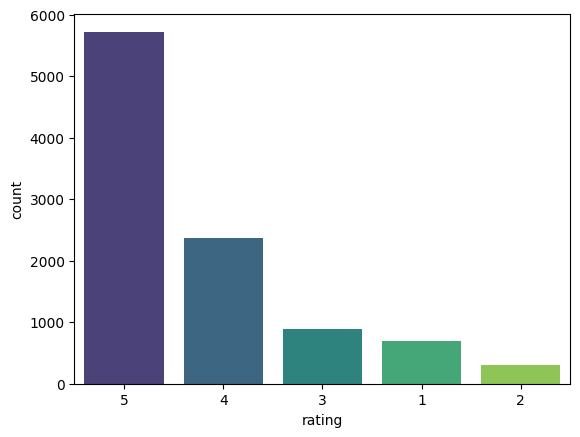

In [83]:
sns.countplot(
    data=data,
    x='rating',
    order=data.rating.value_counts().index,
    palette='viridis'  # Choose a color palette
)

plt.show()


To predict the Sentiment as positive(numerical value = 1) or negative(numerical value = 0), we need to change the rating column into an another column of 0s and 1s category. For that the condition will be like if the rating is less than or equal to 4, then it is negative(0) else positive(1). For better understanding, refer the code below.

In [84]:
# rating label(final)
pos_neg = []
for i in range(len(data['rating'])):
    if data['rating'][i] >= 5:
        pos_neg.append(1)
    else:
        pos_neg.append(0)

data['label'] = pos_neg

Let’s create the function to preprocess the dataset

In [85]:
from tqdm import tqdm


def preprocess_text(text_data):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        # Removing punctuations
        sentence = re.sub(r'[^\w\s]', '', sentence)

        # Converting lowercase and removing stopwords
        preprocessed_text.append(' '.join(token.lower()
                                          for token in nltk.word_tokenize(sentence)
                                          if token.lower() not in stopwords.words('english')))

    return preprocessed_text

Now, we can implement this function for the dataset. The code for that is given below.

In [86]:
!pip install nltk
import nltk

# Download the 'punkt' resource
nltk.download('punkt')

from tqdm import tqdm
import re
from nltk.corpus import stopwords

def preprocess_text(text_data):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        # Removing punctuations
        sentence = re.sub(r'[^\w\s]', '', sentence)

        # Converting lowercase and removing stopwords
        preprocessed_text.append(' '.join(token.lower()
                                          for token in nltk.word_tokenize(sentence)
                                          if token.lower() not in stopwords.words('english')))

    return preprocessed_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Once we have done with the preprocess. Let’s see the top 5 rows to see the improved dataset.

In [87]:
data.head()

,review,rating,label
0,It was nice produt. I like it's design a lot. ...,5,1
1,awesome sound....very pretty to see this nd th...,5,1
2,awesome sound quality. pros 7-8 hrs of battery...,4,0
3,I think it is such a good product not only as ...,5,1
4,awesome bass sound quality very good bettary l...,5,1


# Analysis of the Dataset

Let’s check out that how many counts are there for positive and negative sentiments.

In [88]:
data["label"].value_counts()

,count
label,
1,5726
0,4250


To have the better picture of the importance of the words let’s create the Wordcloud of all the words with label = 1 i.e. positive

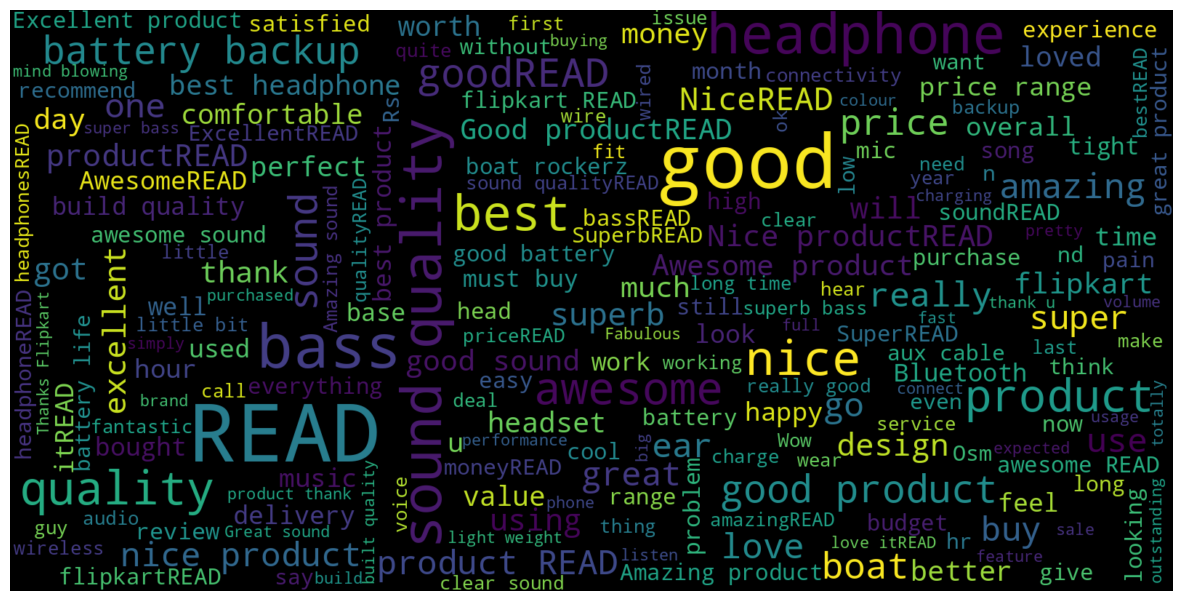

In [89]:
consolidated = ' '.join(
    word for word in data['review'][data['label'] == 1].astype(str))
wordCloud = WordCloud(width=1600, height=800,
                      random_state=21, max_font_size=110)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

Now it’s clear that the words like good, nice, READ have high frequency in positive review, which satisfies our assumptions.

Let’s create the vectors.

# Converting text into Vectors

TF-IDF calculates that how relevant a word in a series or corpus is to a text. The meaning increases proportionally to the number of times in the text a word appears but is compensated by the word frequency in the corpus (data-set). We will be implementing this with the code below.

In [90]:
cv = TfidfVectorizer(max_features=2500)
X = cv.fit_transform(data['review'] ).toarray()

To Print the X generated

In [91]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Model training, Evaluation, and Prediction

Once analysis and vectorization is done. We can now explore any machine learning model to train the data. But before that perform the train-test split.

In [92]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data['label'],
                                                    test_size=0.33,
                                                    stratify=data['label'],
                                                    random_state=42)

Now we can train any model, Let’s explore the Decision Tree for the prediction.

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score # import the missing module

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train,y_train)

#testing the model
pred = model.predict(X_train)
print(accuracy_score(y_train,pred))

0.9362561723776747


Let’s see the confusion matrix for the results.

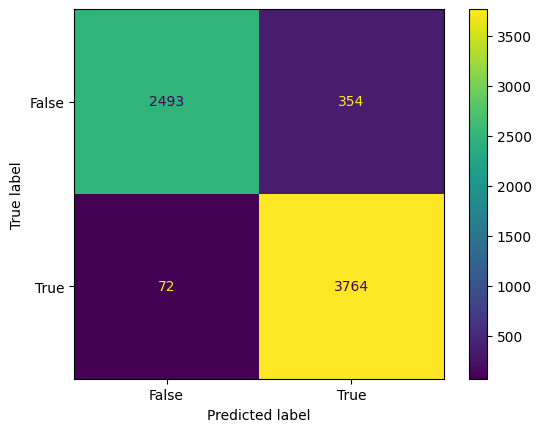

In [94]:
from sklearn import metrics
cm = confusion_matrix(y_train,pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = [False, True])

cm_display.plot()
plt.show()